In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

torch.cuda.get_device_name(0)

1.7.0
True


'Tesla P100-PCIE-16GB'

In [3]:
package_paths=[
    '../input/pytorch-image-models/pytorch-image-models-master',
    '../input/image-fmix/FMix-master'
]
import sys; 
for package_path in package_paths:
    sys.path.append(package_path)

from fmix import sample_mask

In [4]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold,KFold
import cv2
from skimage import io
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from  torch.cuda.amp import autocast, GradScaler #自动、混合精度
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
import timm #from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from sklearn.metrics import log_loss

## parameters

In [5]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512, #?
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'accum_iter': 1,
    'num_workers': 5,
    'verbose_step': 5,
    'device':  torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'weights': [1,1,1,1],
    'weight_decay':1e-6
}

## seed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## image data check

In [7]:
train_path = '../input/cassava-leaf-disease-classification/train_images/'
test_path = '../input/cassava-leaf-disease-classification/test_images/'

train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

In [8]:
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:
submission.head()

,image_id,label
0,2216849948.jpg,4


In [10]:
X_train, y_train = train['image_id'].values, train['label'].values
X_train,y_train

(array(['1000015157.jpg', '1000201771.jpg', '100042118.jpg', ...,
        '999474432.jpg', '999616605.jpg', '999998473.jpg'], dtype=object),
 array([0, 3, 1, ..., 1, 4, 4]))

In [11]:
X_test = [name for name in (os.listdir(test_path))]
X_test

['2216849948.jpg']

## Helper Functions

In [12]:
#reverse
line = "abcde"
line[::-1]

'edcba'

In [13]:
#get a img sample
def get_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:,:,::-1]
#     print(img_bgr)
#     print('------')
#     print(img_rgb)
    return img_rgb

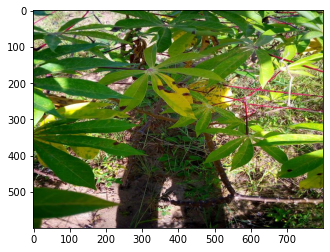

In [14]:
img = get_img('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

## dataset

In [15]:
class LeafDataset(Dataset):
    def __init__(self,df,data_root,transforms=None,img_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.img_label = img_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,index: int):
        # get label
        if self.img_label:
            target = self.df.iloc[index]['label']
        
        path = "{}/{}".format(self.data_root,self.df.iloc[index]['image_id'])
        
        img = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
        
        # do label smoothing
        
        if self.img_label == True: # if label exists so it is a train img
            return img,target
        else:
            return img

## transform

In [16]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

In [17]:
def get_train_transforms():
    return Compose([
            #将给定图像随机裁剪为不同的大小和宽高比，然后缩放所裁剪得到的图像为制定的大小；（即先随机采集，然后对裁剪得到的图像缩放为同一大小）
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            # 转置
            Transpose(p=0.5),
            HorizontalFlip(p=0.5), #img翻转 
            VerticalFlip(p=0.5),# 依据概率p对PIL图片进行垂直翻转
            ShiftScaleRotate(p=0.5),# 随机放射变换（ShiftScaleRotate），该方法可以对图片进行平移（translate）、缩放（scale）和旋转（roatate）
            # 随机改变图片的 HUE、饱和度和值
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            #随机亮度对比度
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            #将像素值除以255 = 2 ** 8 - 1，减去每个通道的平均值并除以每个通道的std
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            # 在图像上生成矩形区域。
            CoarseDropout(p=0.5),
            # 在图像中生成正方形区域。
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_valid_transforms():
    return Compose([
        CenterCrop(CFG['img_size'],CFG['img_size'],p=1.),
        Resize(CFG['img_size'],CFG['img_size']),
        Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225],max_pixel_value=255.0,p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.)


def get_inference_transforms():
    return Compose([
        #随机裁剪大小
        RandomResizedCrop(CFG['img_size'],CFG['img_size']),
        #转置
        Transpose(p=0.5),
        #翻转
        HorizontalFlip(p=0.5),
        #垂直翻转
        VerticalFlip(p=0.5),
        #随机色调，饱和度
        HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        #随机亮度对比度
        RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        #Normalize归一化
        Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225],max_pixel_value=255.0,p=1.0),
        ToTensorV2(p=1.),
    ],p=1.)

## Cutmix and Fmix

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,40

In [19]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    #mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device)*data
    x2 = torch.from_numpy(1-mask).to(device)*shuffled_data
    targets=(targets, shuffled_targets, lam)
    
    return (x1+x2), targets

## Dataloader

In [20]:

def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    
    train_ds = LeafDataset(train,data_root,transforms=get_train_transforms(),img_label=True)
    valid_ds = LeafDataset(valid_,data_root, transforms=get_valid_transforms(), img_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

## Model

In [21]:
class LeafClassifier(nn.Module):
    def __init__(self,model_name,n_class,pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name,pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features,n_class)
        
    def forward(self,x):
        x = self.model(x)
        return x

In [22]:
class EnsembleModel(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        if model_arch == 'tf_efficientnet_b4_ns':
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)
        if model_arch == 'resnext50_32x4d':
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, n_class)
        if model_arch == 'vit_base_patch16_384':
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x

## Focal Loss

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight

    def forward(self, input_, target):
        ce_loss = F.cross_entropy(input_, target,reduction=self.reduction,weight=self.weight) 
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

# loss_tr = FocalLoss().to(device); loss_fn = FocalLoss().to(device)

## train one epoch

In [24]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        mix_decision = np.random.rand()
        if mix_decision < 0.25:
            imgs, image_labels = cutmix(imgs, image_labels, 1.)
        elif mix_decision >=0.25 and mix_decision < 0.5:
            imgs, image_labels = fmix(imgs, image_labels, alpha=1., decay_power=5., shape=(CFG['img_size'],CFG['img_size']))
        
        optimizer.zero_grad()
        
        with autocast():
#             image_preds = model(imgs)   
            image_preds = model(imgs.float())

#             loss = loss_fn(image_preds, image_labels)
            if mix_decision < 0.50:
                loss = loss_fn(image_preds, image_labels[0]) * image_labels[2] + loss_fn(image_preds, image_labels[1]) * (1. - image_labels[2])
            else:
                loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()
#         loss.backward()
#         optimizer.step()
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01
                
        if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()

## valid one epoch

In [25]:
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

## interence one epoch

In [26]:
def inference_one_epoch(model,data_loader,device):
    model.eval()
    image_preds_all = []
    pbar = tqdm(enumerate(data_loader),total=len(data_loader))
    
    for step,imgs in pbar:
        imgs = imgs.to(device).float()
        image_preds = model(imgs) #ooutput=model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    image_preds_all = np.concatenate(image_preds_all,axis=0)
    return image_preds_all

## Main Loop

In [27]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch
    seed_everything(CFG['seed'])
    # K则，并分层抽样
    folds = StratifiedKFold(n_splits=CFG['fold_num']).split(np.arange(train.shape[0]),train.label.values)
    device = torch.device(CFG['device'])
    model = LeafClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
#     loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
#     loss_fn = nn.CrossEntropyLoss().to(device)
    loss_tr = FocalLoss().to(device); 
    loss_fn = FocalLoss().to(device)
    for fold,(trn_idx,val_idx) in enumerate(folds):
        # we'll train flod 0 first
        if fold>0:
            break
        print('Inference fold {} started'.format(fold))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/')
        
        scaler = GradScaler()  
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        best_accuracy = 0
        best_epoch = 0
        
        for epoch in range(CFG['epochs']):
            print(epoch)
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device,scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                epoch_accuracy = valid_one_epoch(epoch, model, loss_fn, val_loader, device)
            
#             if epoch_accuracy > best_accuracy:
#                 torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
#                 best_accuracy = epoch_accuracy
#                 best_epoch = epoch
#                 print('The model is saved!')
            torch.save(model.state_dict(),'{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader
        torch.cuda.empty_cache()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


Inference fold 0 started
0


epoch 0 loss: 0.0483: 100%|██████████| 134/134 [01:25<00:00,  1.56it/s]


validation multi-class accuracy = 0.8741
1


epoch 1 loss: 0.0375: 100%|██████████| 134/134 [01:27<00:00,  1.53it/s]


validation multi-class accuracy = 0.8937
2


epoch 2 loss: 0.0341: 100%|██████████| 134/134 [01:25<00:00,  1.56it/s]


validation multi-class accuracy = 0.8993
3


epoch 3 loss: 0.0307: 100%|██████████| 134/134 [01:19<00:00,  1.68it/s]


validation multi-class accuracy = 0.9019
4


epoch 4 loss: 0.0276: 100%|██████████| 134/134 [01:19<00:00,  1.68it/s]


validation multi-class accuracy = 0.9049
5


epoch 5 loss: 0.0260: 100%|██████████| 134/134 [01:18<00:00,  1.71it/s]


validation multi-class accuracy = 0.9100
6


epoch 6 loss: 0.0209: 100%|██████████| 134/134 [01:20<00:00,  1.66it/s]


validation multi-class accuracy = 0.9114
7


epoch 7 loss: 0.0202: 100%|██████████| 134/134 [01:15<00:00,  1.78it/s]


validation multi-class accuracy = 0.9150
8


epoch 8 loss: 0.0187: 100%|██████████| 134/134 [01:20<00:00,  1.67it/s]


validation multi-class accuracy = 0.9194
9


epoch 9 loss: 0.0179: 100%|██████████| 134/134 [01:27<00:00,  1.52it/s]


validation multi-class accuracy = 0.9187
